### pandas-profiling install

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

### mlxtend install which is used for OneR model

In [ ]:
pip install mlxtend==0.21.0

### Standard Imports

In [ ]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression   #Logit model
from sklearn.naive_bayes import GaussianNB            #NaiveBayes model
from sklearn.tree import DecisionTreeClassifier       #DecisionTree model
from sklearn.svm import SVC                           #SVM model
from sklearn.ensemble import RandomForestClassifier   #RandomForest model
from sklearn.dummy import DummyClassifier             #ZeroR model
from mlxtend.classifier import OneRClassifier         #OneR model

from sklearn.metrics import confusion_matrix, roc_curve, RocCurveDisplay, roc_auc_score, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, StratifiedKFold

### Q1. Create a HTML profile report of the `red_wine` data.

In [ ]:
red_wine_df = pd.read_csv('red_wine.csv')
profile = pp.ProfileReport(red_wine_df)
profile.to_file("report.html")

### Q2. Table of accuracy and auc-roc scores of different algorithms

In [ ]:
X = red_wine_df.drop('type', axis=1)
y = red_wine_df['type'].map({'high':1, 'low':0})

In [ ]:
def df_to_binned(df, bins):
  df1 = df.copy()
  for col in df1.columns:
    col_name = col+'_binned'
    df1[col_name] = pd.cut(df1[col], bins=bins)
    df1.drop(col, axis=1, inplace=True)
  return df1

In [ ]:
def results_to_frame(models, X, y, n_bins, n_folds):
  results_df = pd.DataFrame(columns=['model', 'AUC', 'Accuracy'])
  cv = KFold(n_folds)
  for model in models:
    if model=='ZeroR':
      zeror = DummyClassifier()
      acc = cross_val_score(zeror, X, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'ZeroR', 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
    elif model=='OneR':
      X_arr = df_to_binned(X, bins=n_bins).to_numpy()
      oner = OneRClassifier()
      acc = cross_val_score(oner, X_arr, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'OneR', 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
    elif model=='LR':
      lr = LogisticRegression()
      auc = cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')
      acc = cross_val_score(lr, X, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'LR', 'AUC':round(np.mean(auc),3), 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
    elif model=='NB':
      nb = GaussianNB()
      auc = cross_val_score(nb, X, y, cv=cv, scoring='roc_auc')
      acc = cross_val_score(nb, X, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'NB', 'AUC':round(np.mean(auc),3), 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
    elif model=='DT':
      dt = DecisionTreeClassifier(random_state=0)
      auc = cross_val_score(dt, X, y, cv=cv, scoring='roc_auc')
      acc = cross_val_score(dt, X, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'DT', 'AUC':round(np.mean(auc),3), 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
    elif model=='SVM':
      svm = SVC(kernel='poly', random_state=0)
      auc = cross_val_score(svm, X, y, cv=cv, scoring='roc_auc')
      acc = cross_val_score(svm, X, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'SVM', 'AUC':round(np.mean(auc),3), 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
    elif model=='RF':
      rf = RandomForestClassifier(random_state=0)
      auc = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc')
      acc = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
      results_df = results_df.append({'model':'RF', 'AUC':round(np.mean(auc),3), 'Accuracy':round(np.mean(acc),3)}, ignore_index=True)
  results_df.set_index('model', inplace=True)
  return results_df.T

In [ ]:
df = results_to_frame(models=['ZeroR','OneR','LR','NB','DT','SVM','RF'], X=X, y=y, n_bins=5, n_folds=10)
df

model,ZeroR,OneR,LR,NB,DT,SVM,RF
AUC,NaN,NaN,0.874,0.895,0.803,0.856,0.924
Accuracy,0.529,0.778,0.779,0.822,0.809,0.762,0.844


### Q3. ROC curve for RandomForest Classifier

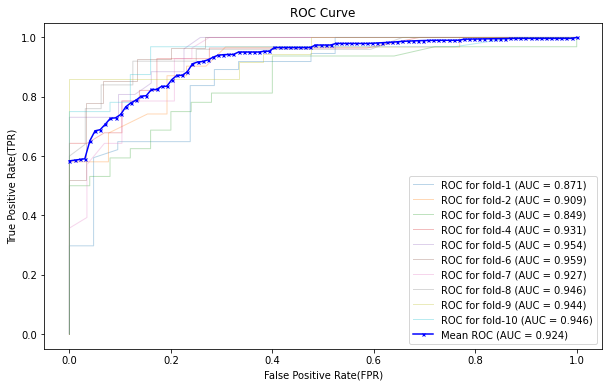

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
cv = KFold(10)
rf = RandomForestClassifier(random_state=0)

tprs = []
fprs = []
fpr_space = np.linspace(0,1,100)
fold=1
for train_index, test_index in cv.split(X, y):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  y_prob = rf.fit(X_train, y_train).predict_proba(X_test)
  fpr, tpr, thr = roc_curve(y_test, y_prob[:,1])
  tprs.append(np.interp(fpr_space, fpr, tpr))
  auc_score = auc(fpr, tpr)
  ax.plot(fpr, tpr, linewidth=1, alpha=0.3,label=f'ROC for fold-{fold} (AUC = {np.round(auc_score,3)})')
  fold += 1

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(fpr_space, mean_tpr)
ax.plot(fpr_space, mean_tpr, color='b', marker='x', markersize=3, label=f'Mean ROC (AUC = {np.round(mean_auc,3)})')

ax.set_xlabel('False Positive Rate(FPR)')
ax.set_ylabel('True Positive Rate(TPR)')
ax.set_title('ROC Curve')
ax.legend();

### Q4. AUC score of best performing model on `white_wine.csv`
- The best performing model is RandomForest

In [ ]:
test_df = pd.read_csv('white_wine.csv')
X_test = test_df.drop('type', axis=1)
y_test = test_df['type'].map({'low':0, 'high':1})
rf = RandomForestClassifier(random_state=0)
y_prob = rf.fit(X,y).predict_proba(X_test)
print(f'The AUC-ROC Score for white_wine.csv is {np.round(roc_auc_score(y_test, y_prob[:,1]),3)}')

The AUC-ROC Score for white_wine.csv is 0.978
